In [150]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os

In [151]:
statedict = {'PA':'Pennsylvania', 'CT':'Connecticut', 'MA':'Massachusetts', 'NH':'New Hampshire', 'DE':'Delaware',
             'NC':'North Carolina', 'GA':'Georgia', 'NY':'New York', 'NJ': 'New Jersey', 'RI':'Rhode Island',
             'VA':'Virginia', 'MD':'Maryland', 'SC':'South Carolina', 'VT':'Vermont'}

## Geography Table

In [153]:
CD_table = pd.read_csv('../Results/CD_table.csv', index_col = 0)
CD_table.loc[CD_table[CD_table['Location'].apply(lambda x: len(x.split(", "))==4)].index, 'Location'] = ['New York City West Ward, New York, New York']
CD_table['Occupations'] = CD_table['Occupations'].apply(lambda x: x.replace('\'','').replace('\"','').strip('][').split(', '))

In [154]:
def processLocation(loc):
    if len(loc) == 1:
        if loc[0] == 'United States':
            return [np.nan, np.nan, np.nan, 'United States']
        elif loc[0].strip() not in list(statedict.values()):
            return [np.nan, np.nan, np.nan, loc[0]]
        else:
            return [np.nan, np.nan, loc[0], 'United States']
    elif len(loc) == 2:
        if loc[1].strip() not in list(statedict.values()):
            return [np.nan, np.nan, loc[0], loc[1]]
        else:
            return [np.nan, loc[0], loc[1], 'United States']
    else:
        return [loc[0], loc[1], loc[2], 'United States']

In [155]:
CD_table[['town', 'county', 'state', 'country']] = CD_table['Location'].apply(lambda x: processLocation(x.split(", "))).values.tolist()
CD_table['state'] = CD_table['state'].apply(lambda x: x.strip() if not pd.isnull(x) else x)
CD_table['town'] = CD_table['town'].apply(lambda x: x.strip() if not pd.isnull(x) else x)
CD_table['county'] = CD_table['county'].apply(lambda x: x.strip() if not pd.isnull(x) else x)
CD_table['country'] = CD_table['country'].apply(lambda x: x.strip() if not pd.isnull(x) else x)

In [156]:
tb = CD_table[['Location','Search Names', '6p_Total', '6p_def_Total', '3p_Total', 'count', 'town', 'county', 'state', 'country']]
tb['Search Names'] = tb['Search Names'].apply(lambda x: x.replace('\'','').replace('\"','').strip('][').split(', '))
tb[['town', 'county', 'state','country']] = tb[['town', 'county', 'state','country']].fillna('')
tb_final = tb.groupby(['town', 'county', 'state','country'])['6p_Total', '6p_def_Total', '3p_Total', 'count'].sum().reset_index()

/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_51945/4258588098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tb['Search Names'] = tb['Search Names'].apply(lambda x: x.replace('\'','').replace('\"','').strip('][').split(', '))
/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_51945/4258588098.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tb[['town', 'county', 'state','country']] = tb[['town', 'county', 'state','country']].fillna('')
/var/folders/5s/dvrxt95949x1pm_sjxm85lj000

In [157]:
count_tb = tb[['town', 'county', 'state','country', 'Search Names']].explode('Search Names').drop_duplicates().groupby(['town', 'county', 'state','country'])['Search Names'].count().reset_index()
count_tb.rename({'Search Names':'# Debtholders'}, axis = 1, inplace = True)

In [158]:
tb_merged = pd.merge(tb_final, count_tb)
tb_merged.rename({'count':'Certificate Count'}, axis = 1, inplace = True)
#tb_merged = tb_merged.replace('', np.nan)

In [159]:
tb_merged['6p_Total_all'] = tb_merged['6p_Total'] + tb_merged['6p_def_Total']

In [160]:
tb_merged['town/county pct (6p)'] = np.round(tb_merged['6p_Total_all'] /
                                             tb_merged.groupby(['state', 'county'])['6p_Total_all'].transform('sum')*100, 2)
tb_merged['county/state pct (6p)'] = np.round(tb_merged.groupby(['state', 'county'])['6p_Total_all'].transform('sum') /
                                         tb_merged.groupby('state')['6p_Total_all'].transform('sum')*100, 2)
tb_merged['state/country pct (6p)'] = np.round(tb_merged.groupby(['state', 'country'])['6p_Total_all'].transform('sum') /
                                          tb_merged.groupby('country')['6p_Total_all'].transform('sum')*100, 2)
tb_merged['country/ovall pct (6p)'] = np.round(tb_merged.groupby('country')['6p_Total_all'].transform('sum') /
                                          tb_merged['6p_Total_all'].sum()*100, 2)
tb_merged['6p_Total'] = tb_merged['6p_Total'].apply(lambda x: round(x, 2))
tb_merged['6p_def_Total'] = tb_merged['6p_def_Total'].apply(lambda x: round(x, 2))
tb_merged['3p_Total'] = tb_merged['3p_Total'].apply(lambda x: round(x, 2))

In [161]:
tb_merged.drop('6p_Total_all', axis = 1).sort_values(['country', 'state', 'county', 'town'], ascending = [False, True, True, True]).to_csv('../Results/geography_table.csv')

## Occupation Table

In [162]:
#basic preprocessing
occ_table = CD_table[['state', 'county', 'Occupations', '6p_Total', '6p_def_Total', '3p_Total']]
occ_table['Occ_str'] = occ_table['Occupations'].astype(str)
occ_table['Occ_str'] = occ_table['Occ_str'].apply(lambda x: x.replace("[\'","").replace("\']","").replace("\'",""))
occ_table['count'] = 1

/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_51945/2855494518.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occ_table['Occ_str'] = occ_table['Occupations'].astype(str)
/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_51945/2855494518.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occ_table['Occ_str'] = occ_table['Occ_str'].apply(lambda x: x.replace("[\'","").replace("\']","").replace("\'",""))
/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_51945/2855494518.py:5

In [163]:
occ_table_grouped = occ_table.groupby(['Occ_str']).agg({'6p_Total':sum, '6p_def_Total':sum, '3p_Total':sum,
                                                        'count':sum}).reset_index()
occ_table_grouped.columns = ['Occupations', '6p_Total', '6p_def_Total', '3p_Total', 'count']
occ_table_grouped['Average (6p)'] = (occ_table_grouped['6p_Total'] + occ_table_grouped['6p_def_Total'])/occ_table_grouped['count']
occ_table_grouped = occ_table_grouped[occ_table_grouped['Occupations'] != ""]
for col in ['6p_Total', '6p_def_Total', '3p_Total', 'count']:
    occ_table_grouped[col+"_pct"] = occ_table_grouped[col]/occ_table_grouped[col].sum()*100


In [164]:
occ_table_grouped.sort_values('6p_Total_pct', ascending = False)['6p_Total_pct'][:5].sum()
occ_table_grouped.sort_values('6p_Total_pct', ascending = False)['count'][:5].sum()/occ_table_grouped.sort_values('6p_Total_pct', ascending = False)['count'].sum()

0.3993610223642173

In [165]:
# use to table table 3
s = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and 'administrator' not in x and 'executor' not in x and 'esquire' not in x and 'gentleman' not in x and 'trustee' not in x)]['6p_Total_pct'].sum()
c = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and 'administrator' not in x and 'executor' not in x and 'esquire' not in x and 'gentleman' not in x and 'trustee' not in x)]['count'].sum()
print(s, c, s/c * occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and 'administrator' not in x and 'executor' not in x and 'esquire' not in x and 'gentleman' not in x and 'trustee' not in x)][['6p_Total', '6p_def_Total']].sum().sum()/100)
s = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x))]['6p_Total_pct'].sum()
c = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x))]['count'].sum()
print(s, c, s/c * occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x))][['6p_Total', '6p_def_Total']].sum().sum()/100)
s = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: 'merchant' not in x and 'trader' not in x and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x))]['6p_Total_pct'].sum()
c = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: 'merchant' not in x and 'trader' not in x and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x))]['count'].sum()
print(s, c, s/c * occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: 'merchant' not in x and 'trader' not in x and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x))][['6p_Total', '6p_def_Total']].sum().sum()/100)

38.315279608794235 399 1445.17777032919
6.552916872533511 15 1125.5508450825976
23.489513082253524 387 572.0348577247596


In [166]:
occ_table_grouped.sort_values('6p_Total', ascending = False).to_csv('../Results/Occupation_table.csv')

### Make for each state

In [340]:
for state_fn in statedict.values():
    occ_table_grouped_s = occ_table[occ_table['state'] == state_fn].groupby(['Occ_str']).agg({'6p_Total': sum, '6p_def_Total': sum,
                                                                                         '3p_Total': sum,'count': sum}).reset_index()
    occ_table_grouped_s.columns = ['Occupations', '6p_Total', '6p_def_Total', '3p_Total', 'count']
    occ_table_grouped_s['state'] = state_fn

    occ_table_grouped_s['Average (6p)'] = occ_table_grouped_s['6p_Total'] / occ_table_grouped_s['count']
    for col in ['6p_Total', '6p_def_Total', '3p_Total', 'count']:
        occ_table_grouped_s[col + "_pct"] = occ_table_grouped_s[col] / occ_table_grouped_s[col].sum() * 100
    for col in occ_table_grouped_s.columns[1:]:
        if col != 'state':
            occ_table_grouped_s[col] = occ_table_grouped_s[col].apply(lambda x: round(x, 2))
    occ_table_grouped_s.sort_values('6p_Total', ascending = False).to_csv(f'../Results/Occupation_states/{state_fn.replace(" ", "_")}_Occupation_table.csv')

## Maps

In [168]:
# make maps folder
for dirs in ['maps', 'maps/statemaps', 'maps/allstates']:
    try:
        os.mkdir("../Results/"+dirs)
    except:
        print("{} folder already exists".format(dirs))

maps folder already exists
maps/statemaps folder already exists
maps/allstates folder already exists


In [169]:
# import map shapefile
map_df = gpd.read_file("../../Data/StateShapeFiles/historicalcounties")

map_df.rename(columns = {'NHGISNAM':'county'}, inplace = True)
map_df.rename(columns = {'STATENAM':'state'}, inplace = True)

map_df.head()

,ID,ID2,OBJECTID,GISJOIN,DECADE,county,NHGISST,NHGISCTY,ICPSRST,ICPSRCTY,ICPSRNAM,state,SHAPE_AREA,SHAPE_LEN,AreaI,Geo_FIPS,geometry
0,11643,59420,1,0900010,1790,Fairfield,090,0010,1,10,FAIRFIELD,Connecticut,1.673889e+09,411293.875529,1.673889e+09,0900010,"MULTIPOLYGON (((-73.71277 41.10770, -73.71157 ..."
1,11644,59421,2,0900030,1790,Hartford,090,0030,1,30,HARTFORD,Connecticut,1.858418e+09,197092.380518,1.858419e+09,0900030,"POLYGON ((-72.99955 41.80002, -72.99752 41.800..."
2,11645,59422,3,0900050,1790,Litchfield,090,0050,1,50,LITCHFIELD,Connecticut,2.656161e+09,236932.296583,2.656167e+09,0900050,"POLYGON ((-73.51778 41.67084, -73.51776 41.671..."
3,11646,59423,165,0900070,1790,Middlesex,090,0070,1,70,MIDDLESEX,Connecticut,9.325004e+08,199607.085852,9.325065e+08,0900070,"MULTIPOLYGON (((-72.74954 41.59314, -72.74564 ..."
4,11647,59424,4,0900090,1790,New Haven,090,0090,1,90,NEW HAVEN,Connecticut,1.528738e+09,312354.008005,1.528726e+09,0900090,"MULTIPOLYGON (((-73.16029 41.43809, -73.16055 ..."


In [170]:
county_count_tb = tb[['county', 'state','country', 'Search Names']].explode('Search Names').drop_duplicates().groupby(['county', 'state','country'])['Search Names'].count().reset_index()
county_count_tb.rename({'Search Names':'# Debtholders'}, axis = 1, inplace = True)

In [171]:
t = CD_table[['State' not in x and 'treasurer' not in y for x, y, in
              zip(CD_table['Search Names'], CD_table['Occupations'])]].drop(1)
t = t[t['6p_Total'] != 0]
t['6p_Total'] = t['6p_Total'] + t['6p_def_Total']
# debt file
map_table = t[['county', 'state', '6p_Total']].fillna('')
map_table_grouped = map_table.groupby(['county', 'state']).sum('6p_Total').reset_index()
map_table_grouped = map_table_grouped[map_table_grouped['state'].apply(lambda x: x in statedict.values())]
map_table_grouped = map_table_grouped[map_table_grouped['county'] != ""]
map_table_grouped['county'] = map_table_grouped['county'].apply(
    lambda x: 'Prince Georges' if x == 'Prince George\'s' else x)
map_table_grouped['county'] = map_table_grouped['county'].apply(lambda x: 'Queen Annes' if x == 'Queen Anne\'s' else x)
map_table_grouped = pd.merge(map_table_grouped, county_count_tb)
map_table_grouped['6p_Total_avg'] = map_table_grouped['6p_Total'] / map_table_grouped['# Debtholders']
#merge data and map data
merged2 = pd.merge(map_df, map_table_grouped, on=['county', 'state'], how='left')
merged2['6p_Total'] = merged2['6p_Total'].fillna(0)

In [172]:
CD_table2 = CD_table.copy()
CD_table2['6p_Total'] = CD_table2['6p_Total'] + CD_table2['6p_def_Total']
# debt file
map_table = CD_table2[['county', 'state', '6p_Total']].fillna('')
map_table_grouped = map_table.groupby(['county', 'state']).sum('6p_Total').reset_index()
map_table_grouped = map_table_grouped[map_table_grouped['state'].apply(lambda x: x in statedict.values())]
map_table_grouped = map_table_grouped[map_table_grouped['county'] != ""]
map_table_grouped['county'] = map_table_grouped['county'].apply(
    lambda x: 'Prince Georges' if x == 'Prince George\'s' else x)
map_table_grouped['county'] = map_table_grouped['county'].apply(lambda x: 'Queen Annes' if x == 'Queen Anne\'s' else x)
map_table_grouped = pd.merge(map_table_grouped, county_count_tb)
map_table_grouped['6p_Total_avg'] = map_table_grouped['6p_Total'] / map_table_grouped['# Debtholders']
#merge data and map data
merged = pd.merge(map_df, map_table_grouped, on=['county', 'state'], how='left')
merged['6p_Total'] = merged['6p_Total'].fillna(0)

In [173]:
def plotState(merged, state, variable = '6p_Total'):
    if state not in statedict.values():
        print("{} is not a valid state".format(state))
        return
    fig, ax = plt.subplots(1, figsize=(20, 12))
    ax.axis('off')

    # get data for particular state
    state_df = merged[merged['state'] == state]
    #state_df[variable] = state_df[variable].apply(lambda x: np.log10(x+1))
    state_max = state_df[variable].max()
    state_df[state_df['state'] == state].apply(lambda merged: ax.annotate(text=merged['county'], fontsize = 7, xy=merged['geometry'].centroid.coords[0], ha='center'), axis=1)

    # colorbar
    sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=0, vmax=state_max))
    sm._A = []
    cbar = fig.colorbar(sm)
    if variable == "6p_Total":
        label = '(base 10) 6% Debt Coupon Stock ($)'
    if variable == "6p_Total_avg":
        label = 'Mean 6% Debt Coupon Stock ($ per Debtholder)'
    if variable == "debt_per_capita":
        label = '6% Debt per Capita Coupon Stock ($ per Individual)'
    if variable == "debt_per_white_male":
        label = '6% Debt per White Male Coupon Stock ($ per White Male)'
    cbar.set_label(label)
    # colormap
    cmap = plt.get_cmap('YlOrRd').copy()
    cmap.set_under('gray')

    state_df[state_df['state'] == state].plot(column=variable, cmap= cmap, linewidth=0.8, ax=ax, edgecolor='0.8', vmin=0, vmax = state_max)
    ax.set_title("Map of Continental Debt {} Across Counties in {}".format(label, state))
    for dirs in ['maps/statemaps/'+variable]:
        try:
            os.mkdir("../Results/"+dirs)
        except:
            pass

    fig.savefig('../Results/{}/{}_{}_map.png'.format(dirs,state, variable), dpi = 200)

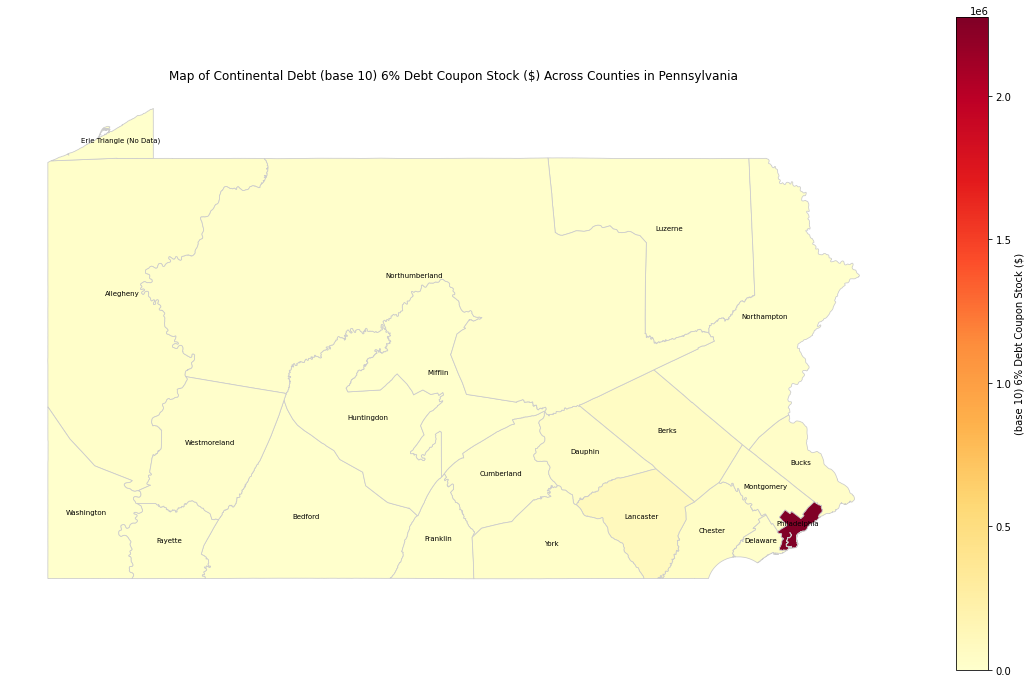

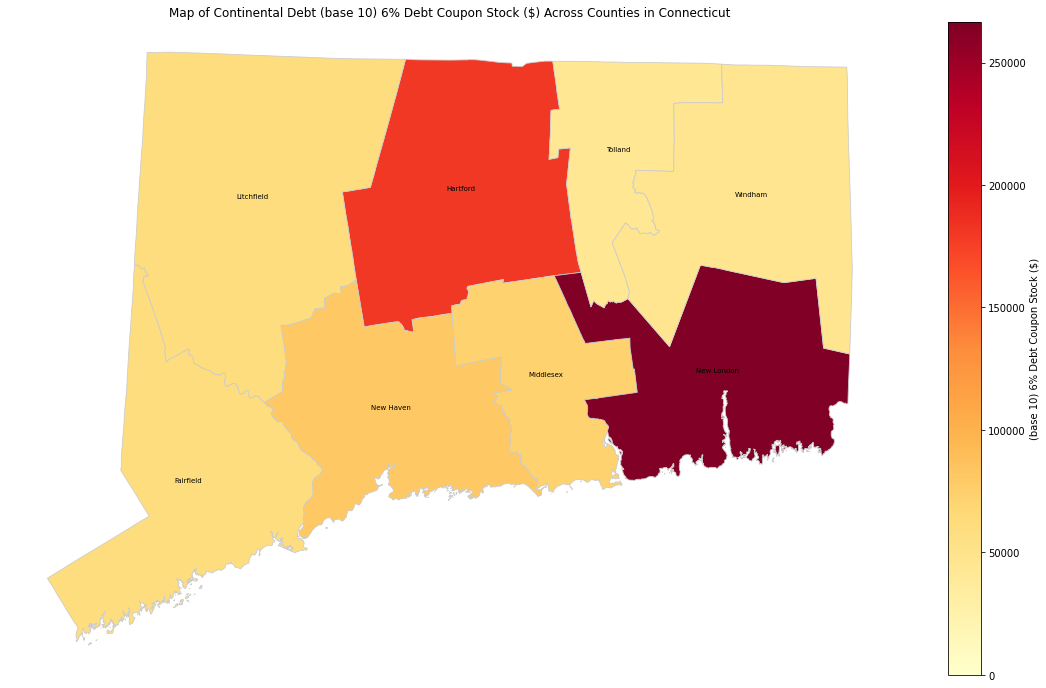

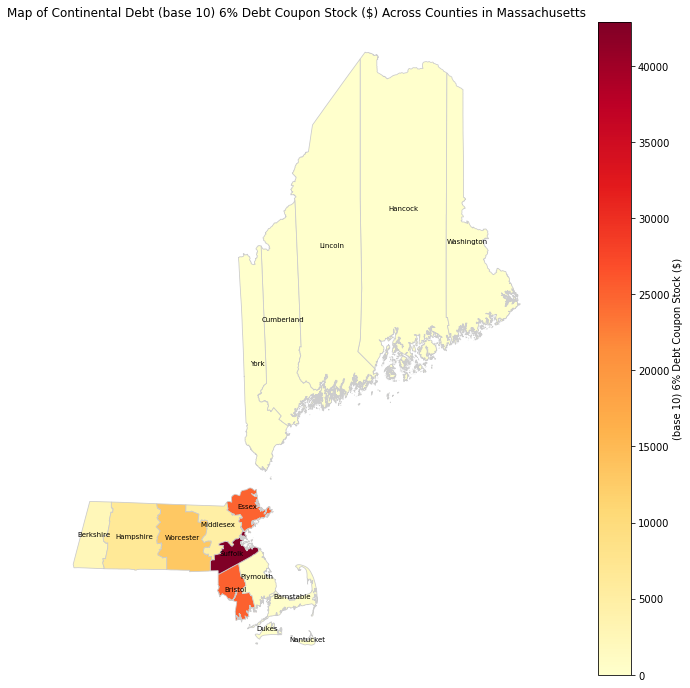

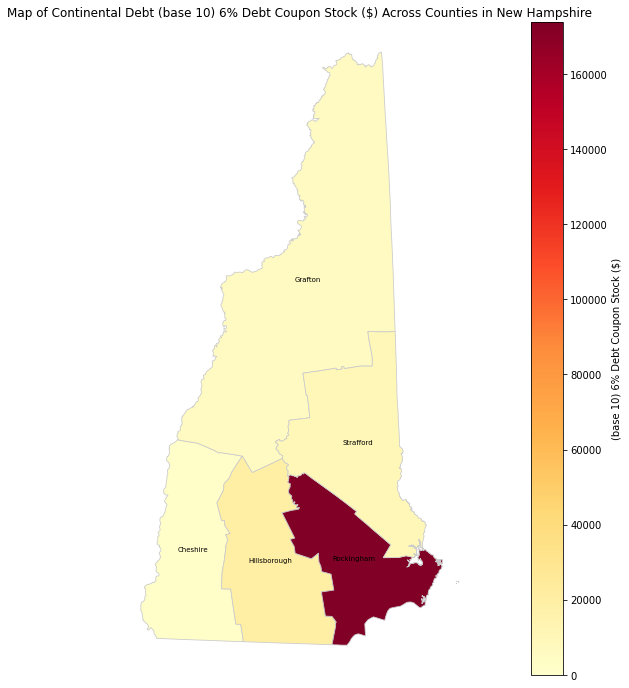

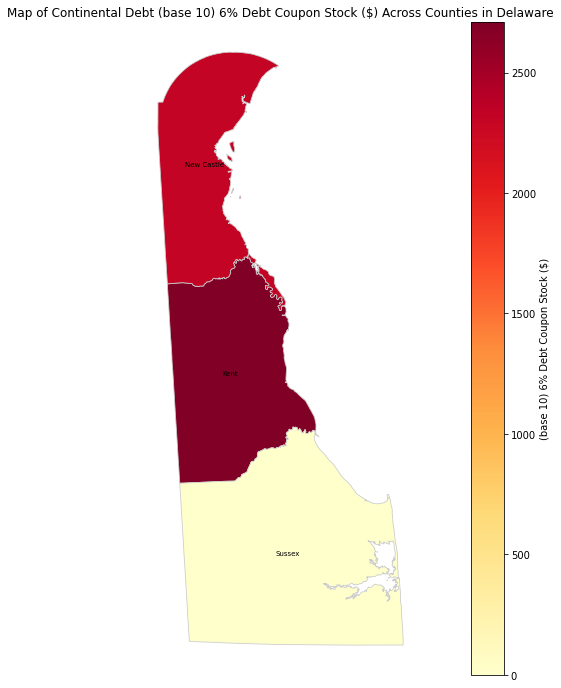

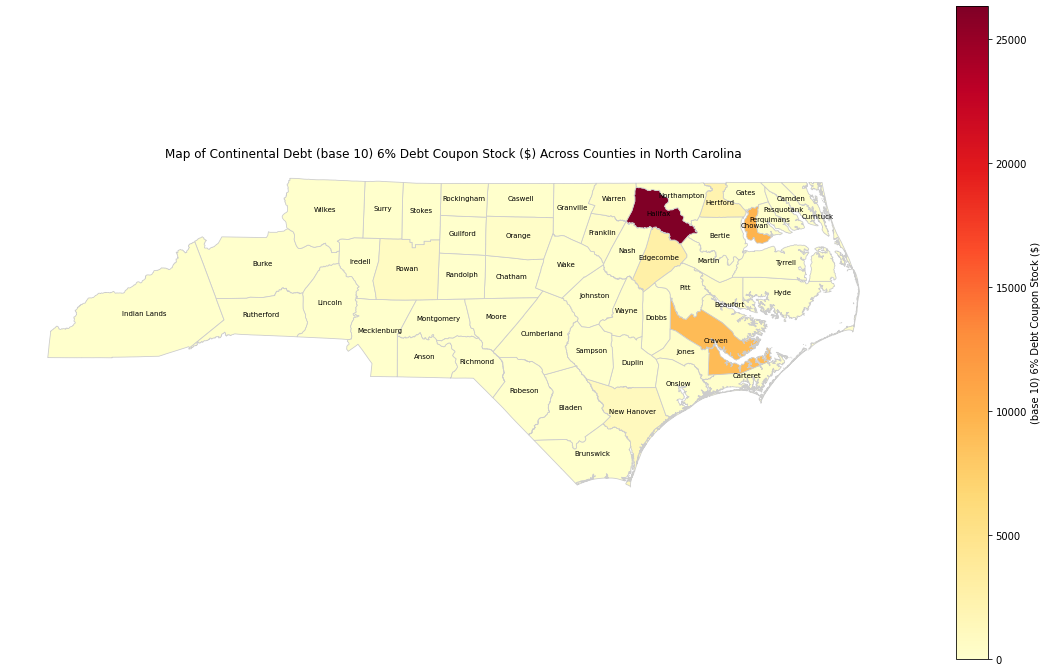

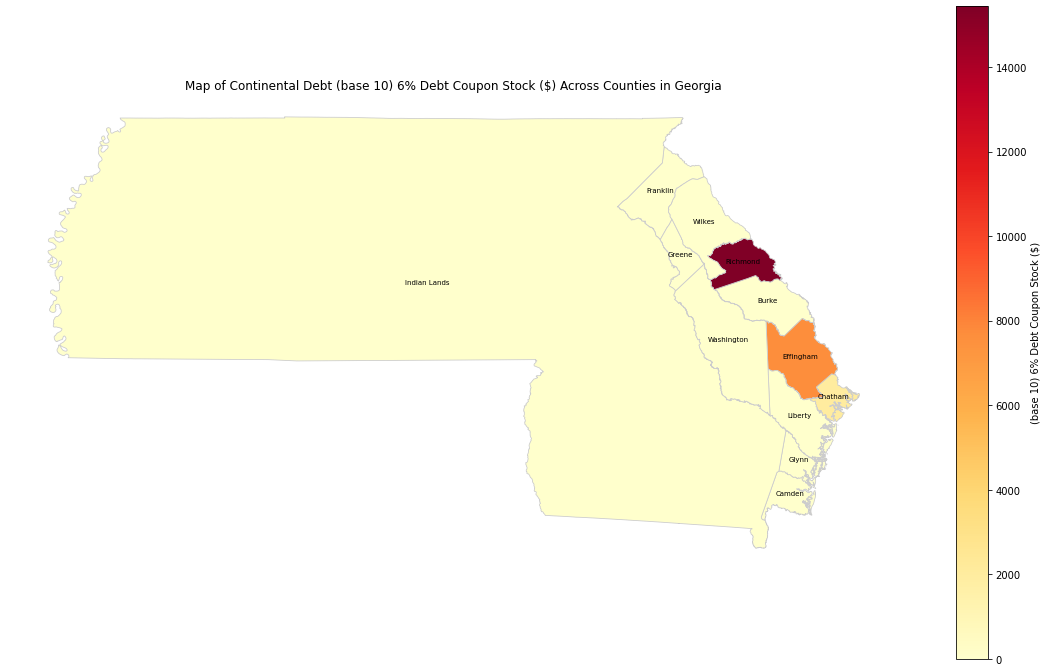

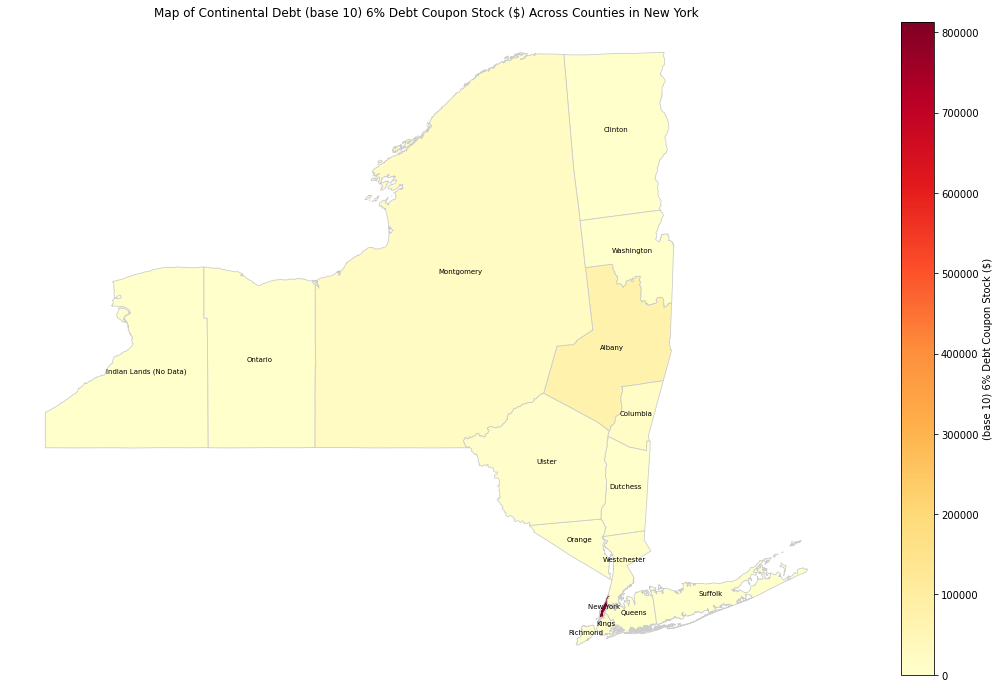

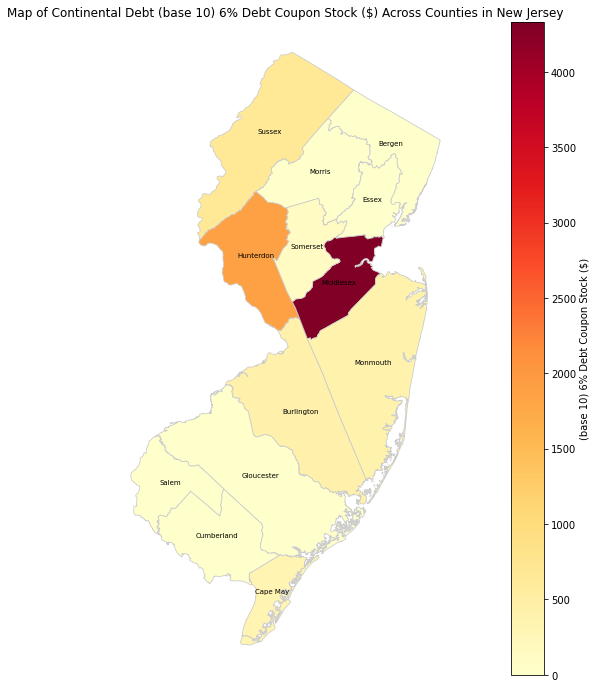

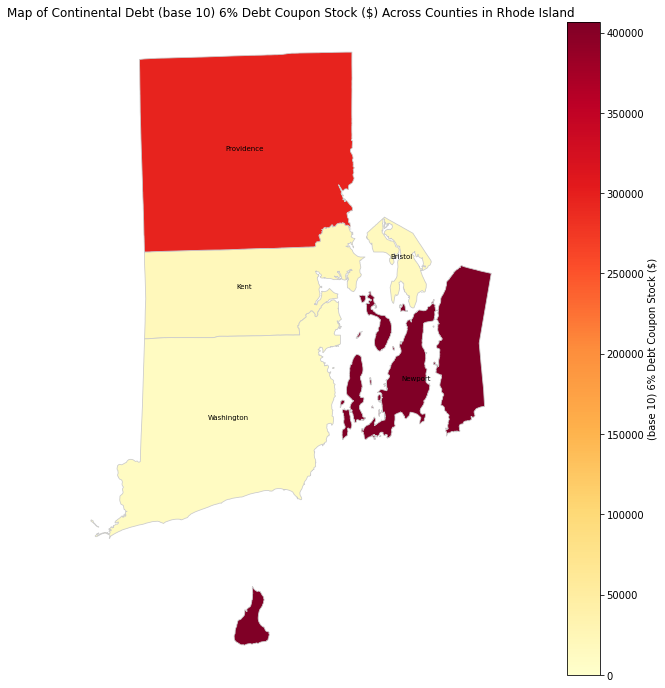

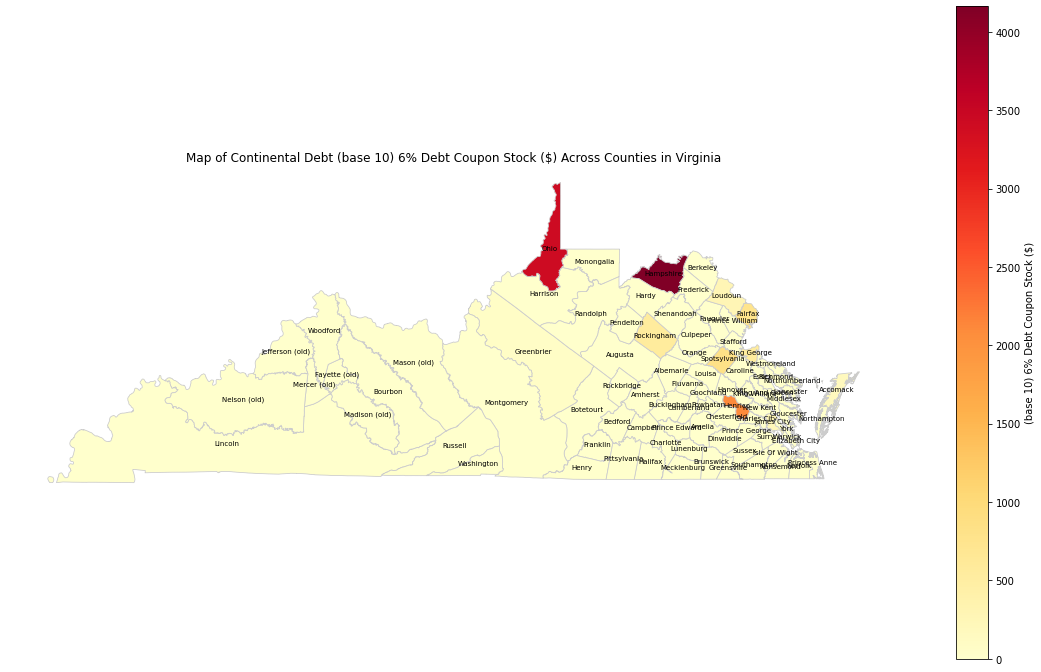

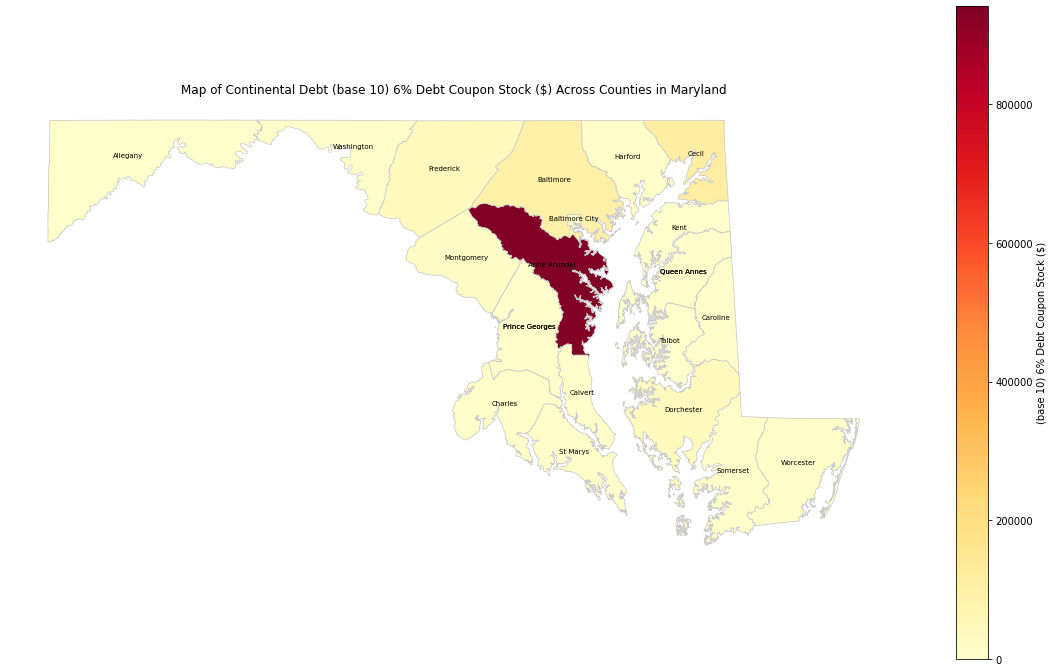

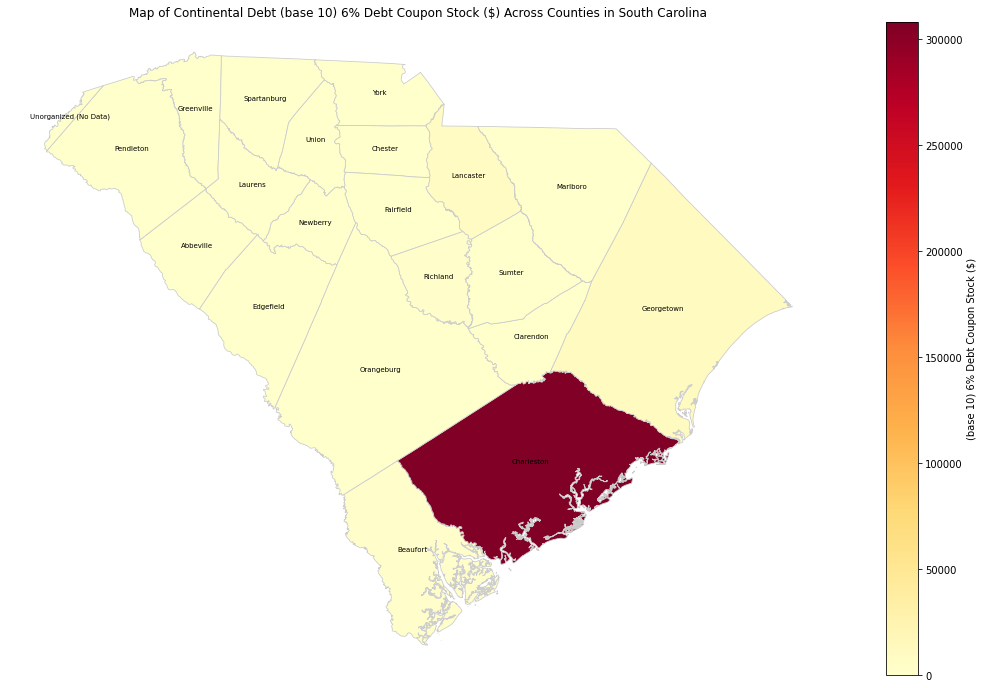

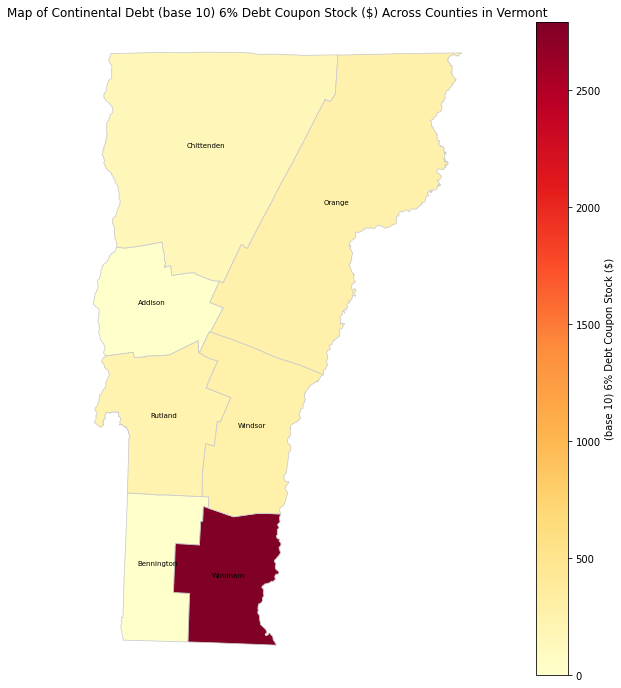

In [174]:
for state in statedict.values():
    plotState(merged, state)

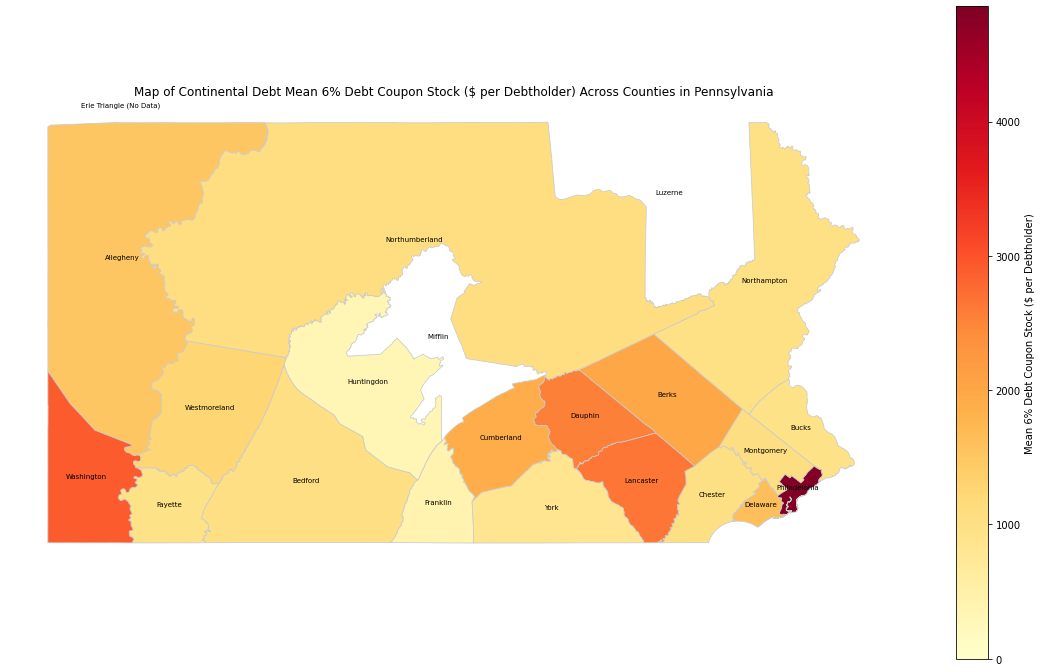

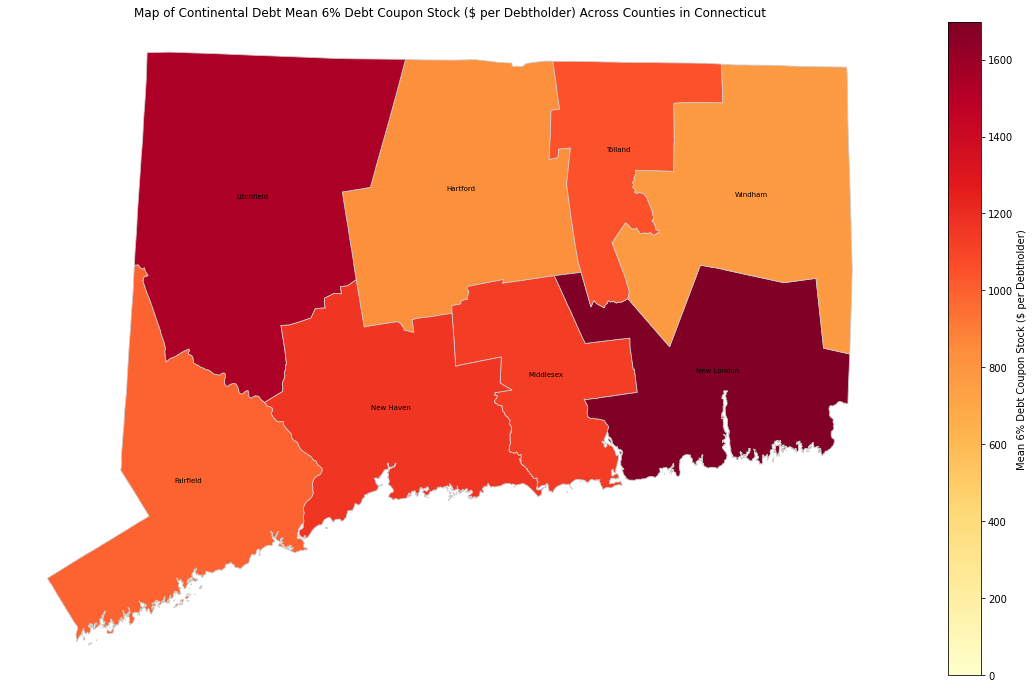

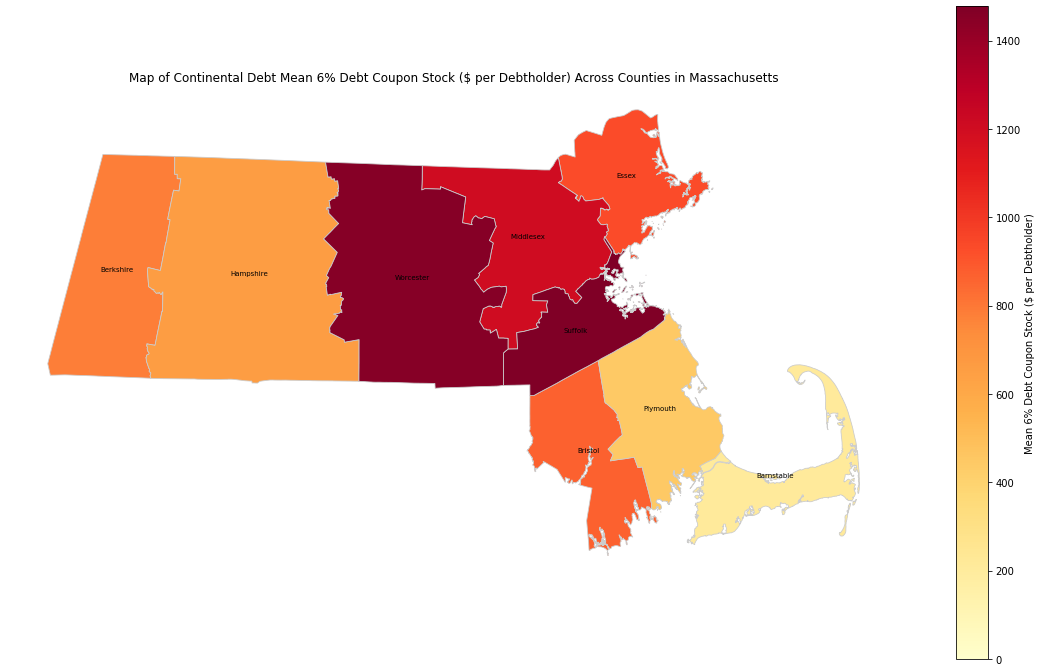

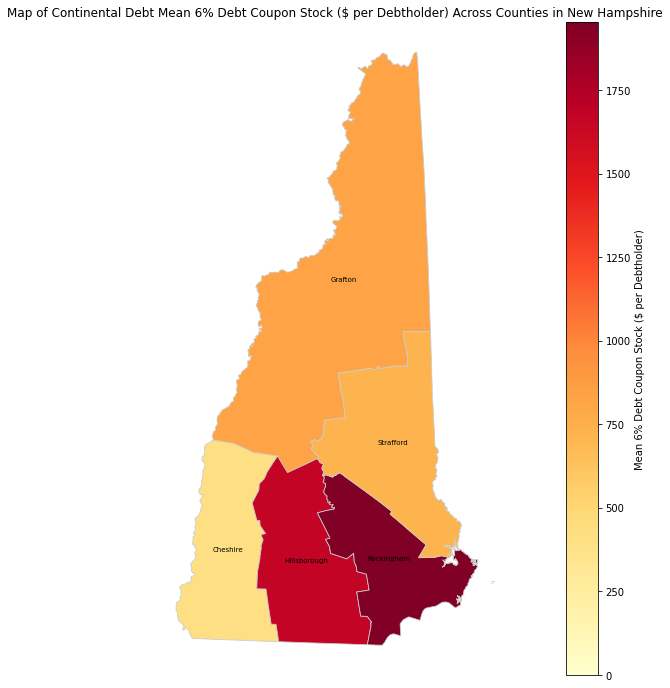

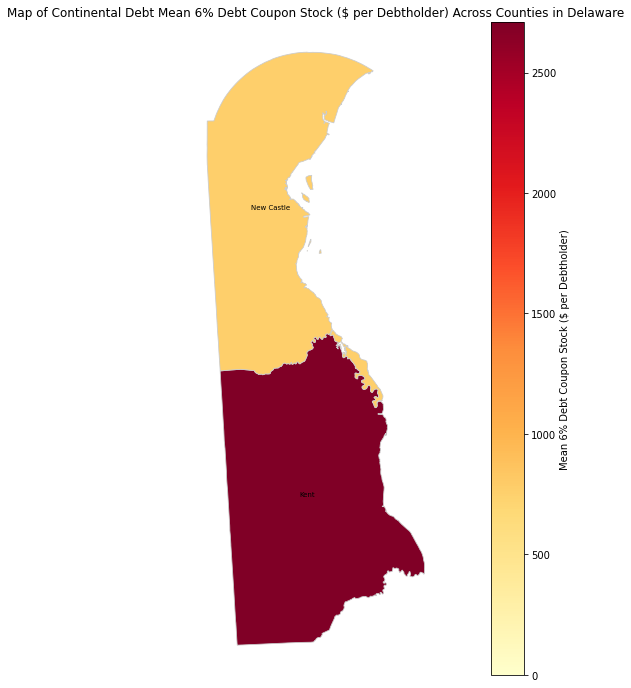

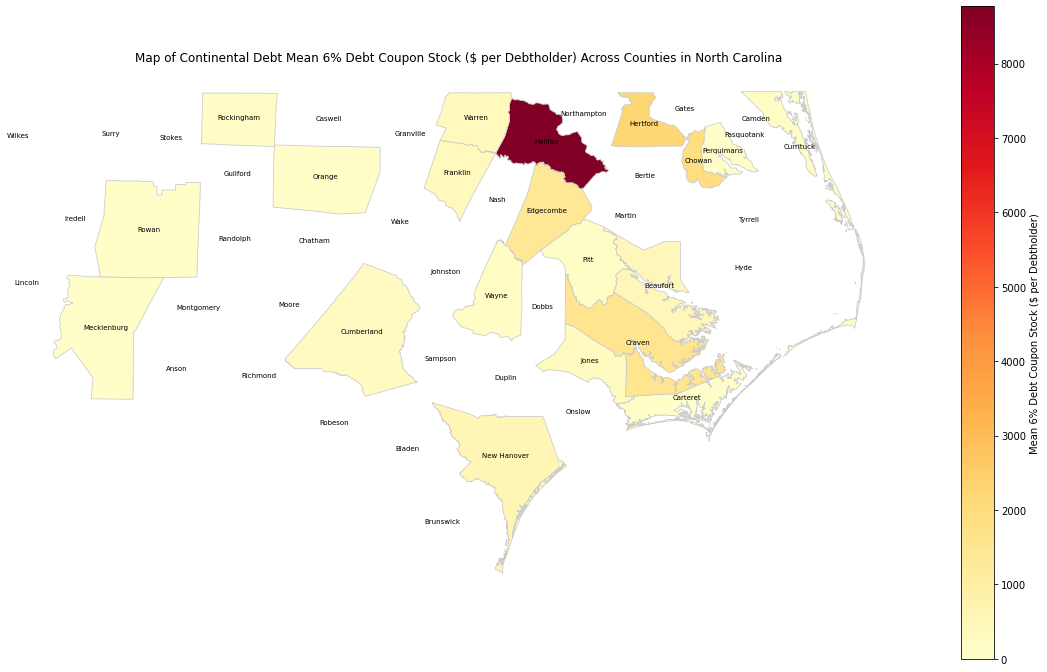

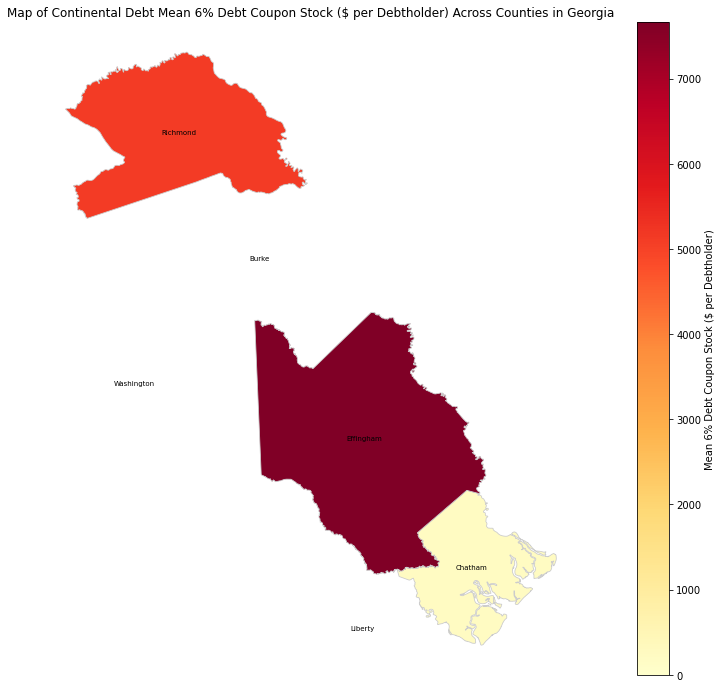

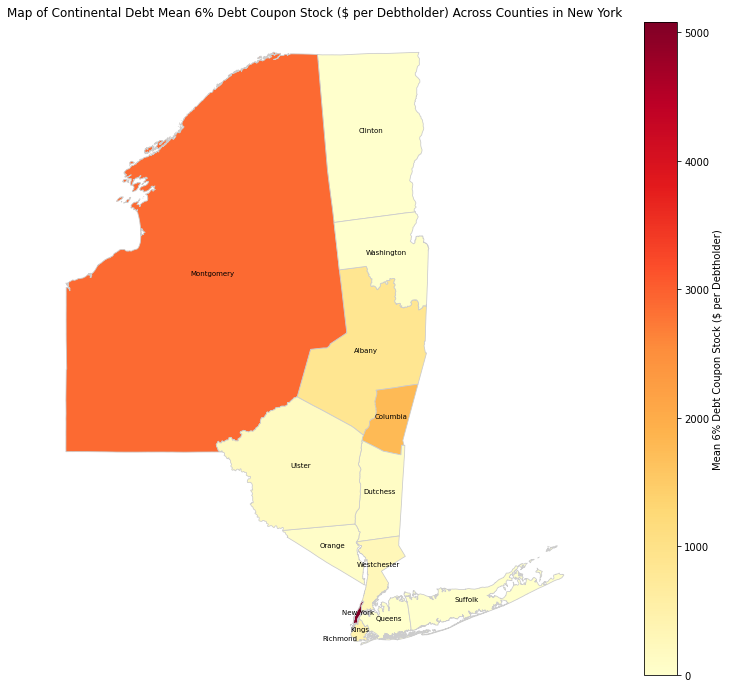

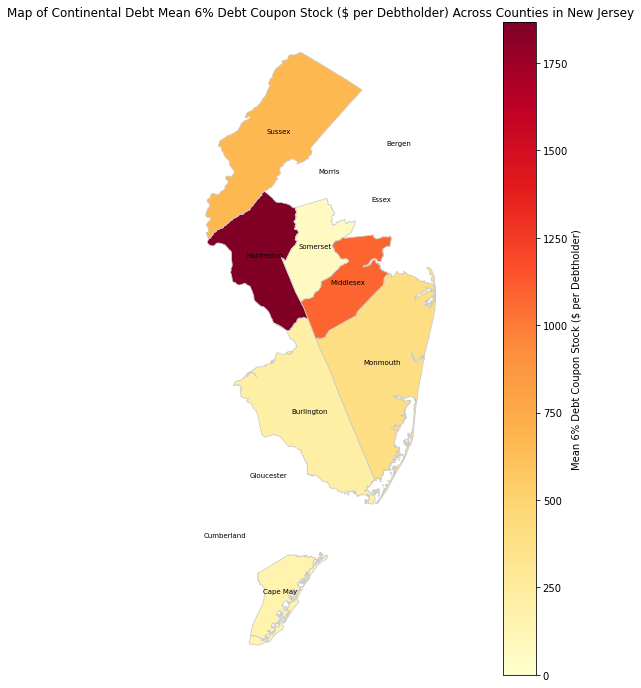

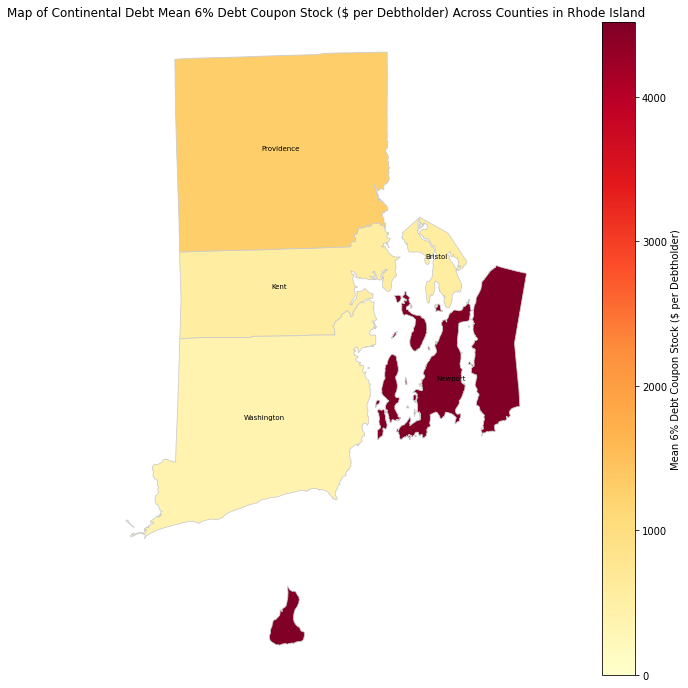

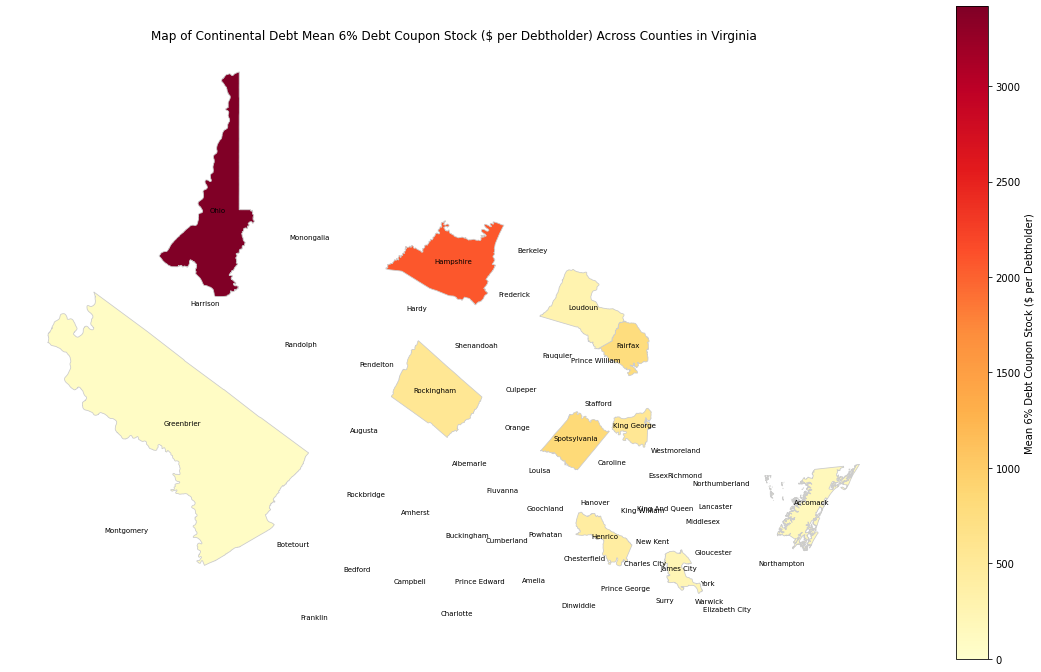

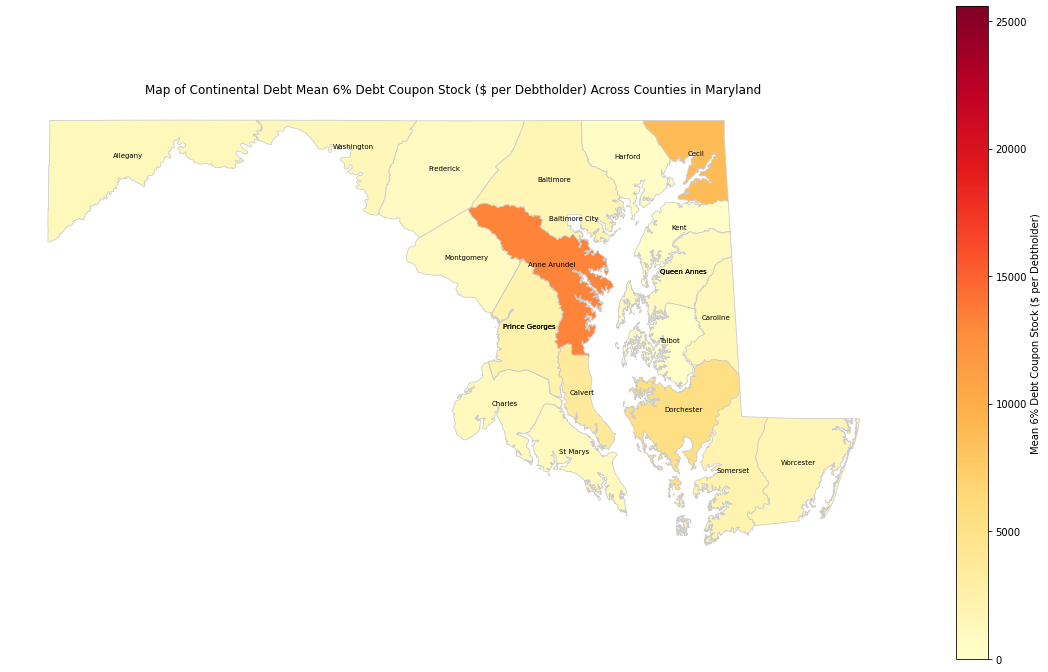

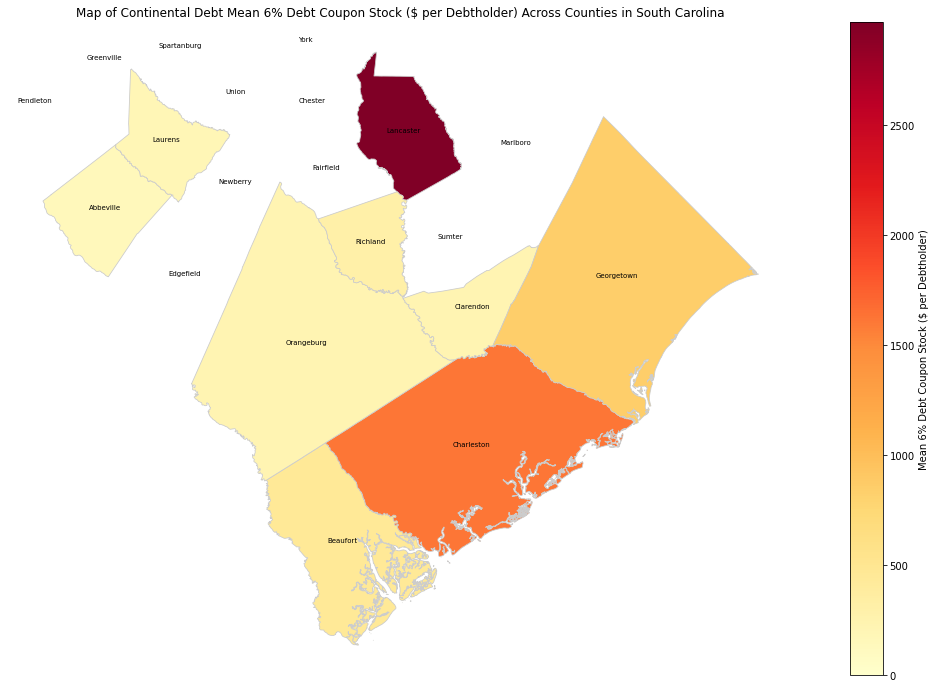

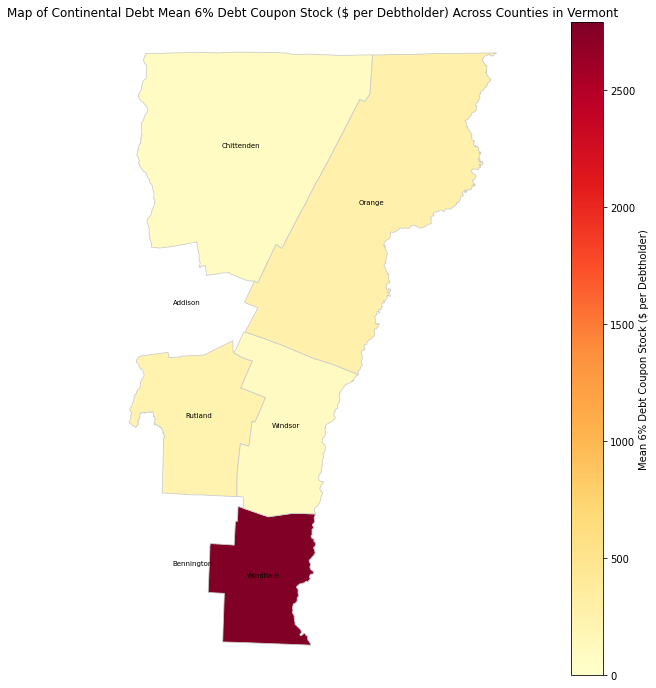

In [175]:
for state in statedict.values():
    plotState(merged, state, '6p_Total_avg')

In [236]:
def plotAllStates(merged, variable, log = "log10", plot = True):
    df = merged.copy()
    df[variable] = df[variable].fillna(0)
    fig, ax = plt.subplots(1, figsize=(20, 12))
    df['centroid'] = df['geometry'].centroid.apply(lambda x: x.coords[0])
    if variable == '6p_Total':
        annot_df = df.groupby('state').agg({'centroid': min, variable: sum}).reset_index()
    if variable == '6p_Total_avg':
        annot_df = df.groupby('state').agg({'centroid': min, variable: 'mean'}).reset_index()

    annot_df = annot_df.sort_values('centroid')
    if log == "log10":
        df[variable] = df[variable].apply(lambda x: np.log10(x+1))
        annot_df[variable] = annot_df[variable].apply(lambda x: np.log10(x+1))
    if log == "nolog":
        pass
    vmin, vmax = 0.01, df[variable].max()
    print(vmax)
    cmap = plt.get_cmap('YlOrRd').copy()
    cmap.set_under('gray')
    cmap.set_over('blue')
    if log == "log10":
        thresh = .85*vmax
    if log == "nolog":
        if variable == '6p_Total_avg':
            thresh = vmax/8
        else:
            thresh = vmax/8
    if variable == '6p_Total_avg':
        df[df[variable]>thresh].apply(lambda merged: ax.annotate(text=merged['county'] + " (" +  str(round(merged[variable], 2)) + ")", fontsize = 5, xy=merged['geometry'].centroid.coords[0], ha='center'), axis=1)
    else:
        if log == "log10":
            df[df[variable]>thresh].apply(lambda merged: ax.annotate(text=merged['county'] + " (" +  str(round(merged[variable], 2)) + ")", fontsize = 5, xy=merged['geometry'].centroid.coords[0], ha='center'), axis=1)
        else:
            df[df[variable]>thresh].apply(lambda merged: ax.annotate(text=merged['county'] + " (" +  str(round(merged[variable], 2)) + ", "+ str(round(merged[variable]/annot_df[variable].sum()*100, 1))+"%)", fontsize = 5, xy=merged['geometry'].centroid.coords[0], ha='center'), axis=1)

    """for i in range(annot_df.shape[0]):
        if variable == '6p_Total':
            if log == "nolog":
                annot_df.loc[[i]].apply(lambda merged: ax.annotate(text= merged['state']+ " Total: " + str(round(merged[variable], 2)) + " ("+str(round(merged[variable]/annot_df[variable].sum()*100, 1))+"%)", fontsize = 10, xy = (-87, 45-.8*i), ha = 'center'), axis=1)
        if variable == '6p_Total_avg':
            annot_df.loc[[i]].apply(lambda merged: ax.annotate(text= merged['state']+ " Average: " + str(round(merged[variable], 2)), fontsize = 10, xy = (-87, 45-.8*i), ha = 'center'), axis=1)
"""
    sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm)
    if variable == "6p_Total":
        label = '6% Debt Coupon Stock ($)'
    if variable == "6p_Total_avg":
        label = 'Mean 6% Debt Coupon Stock ($ per Debtholder)'
    if variable == "debt_per_capita":
        label = '6% Debt per Capita Coupon Stock ($ per Individual)'
    if variable == "debt_per_white_male":
        label = '6% Debt per White Male Coupon Stock ($ per White Male)'
    cbar.set_label(label)

    df.plot(column=variable, cmap= cmap, linewidth=0.8, ax=ax, edgecolor='0.8', vmin=vmin, vmax = vmax)

    ax.axis('off')
    ax.set_title("Map of Continental Debt {} Across All States".format(label))

    if plot:
        fig.savefig('../Results/maps/allstates/{}_{}_map.png'.format(variable, log), dpi = 400)

/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_51945/3948411039.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['centroid'] = df['geometry'].centroid.apply(lambda x: x.coords[0])


2272866.07


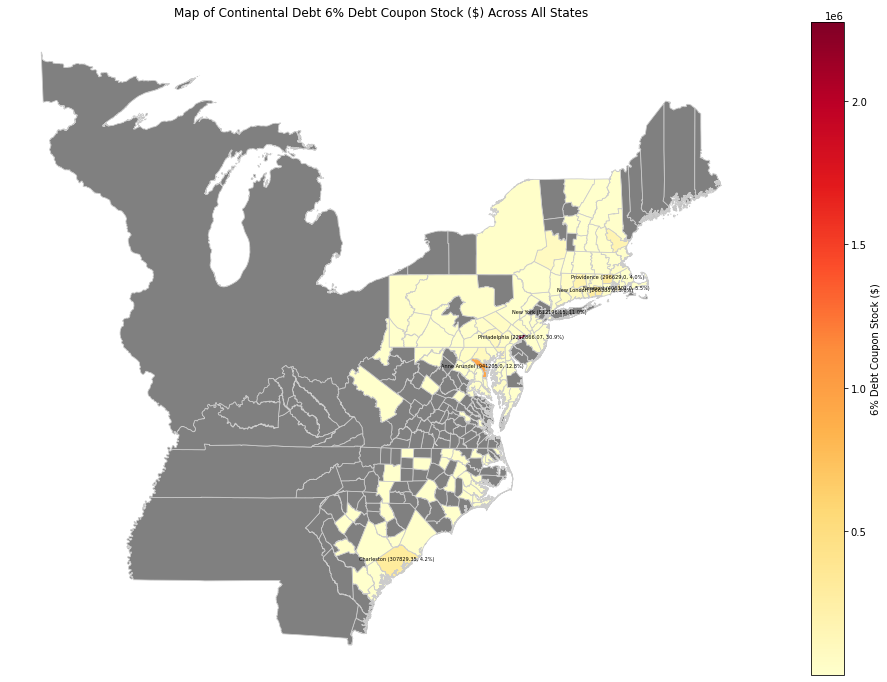

In [196]:
plotAllStates(merged, '6p_Total', log = "nolog")

/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_51945/3948411039.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['centroid'] = df['geometry'].centroid.apply(lambda x: x.coords[0])


6.35657403649327


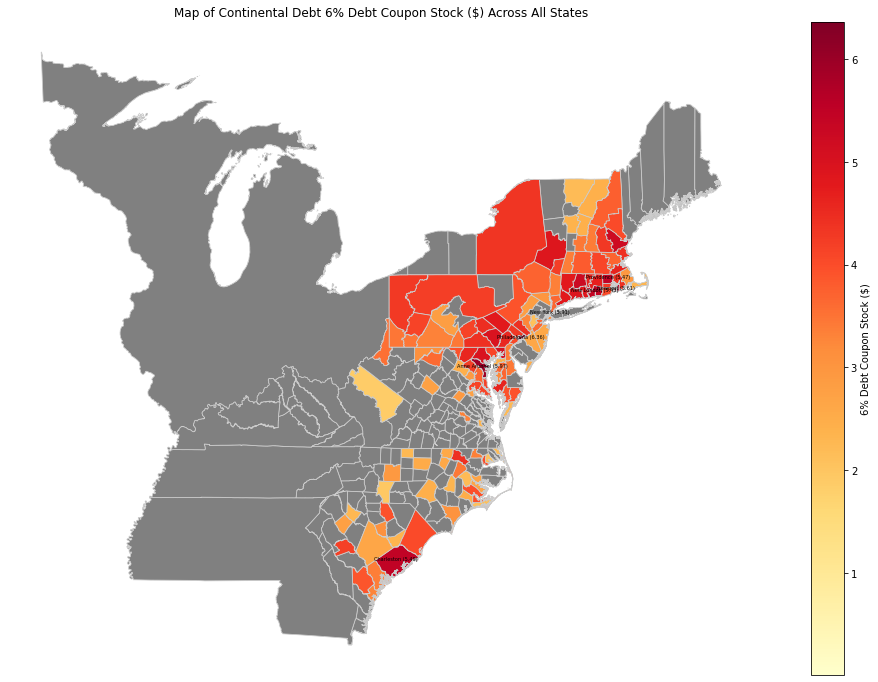

In [192]:
plotAllStates(merged, '6p_Total', log = "log10")

/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_51945/2031018817.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['centroid'] = df['geometry'].centroid.apply(lambda x: x.coords[0])


25575.0


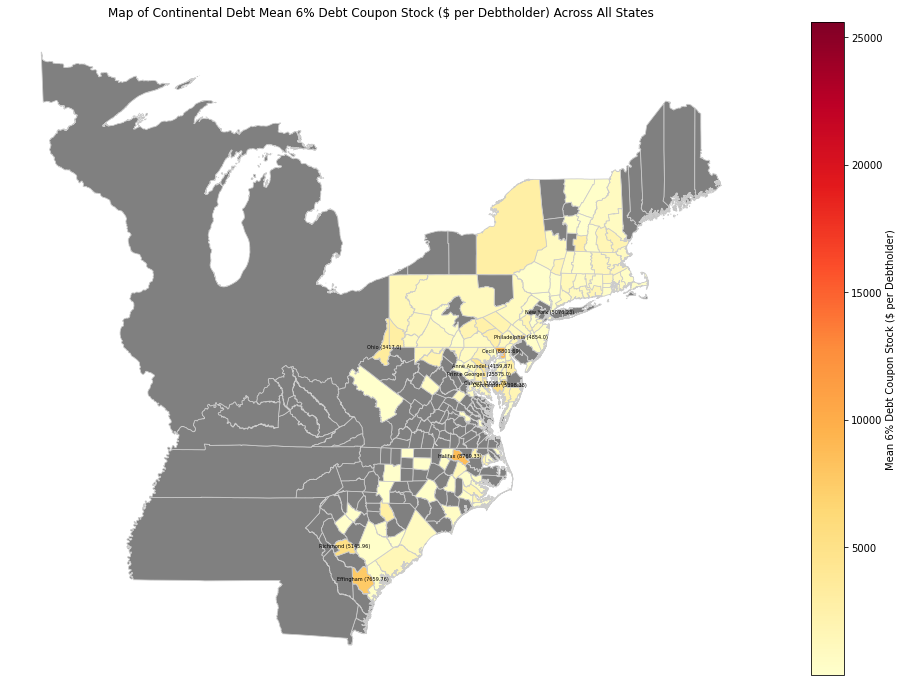

In [237]:
plotAllStates(merged2, '6p_Total_avg', log = "nolog")

## Analysis

### Summary Statistics

In [224]:
print("Unique Groups: {}".format(CD_table.shape[0]))
print("Ledger rows: {}".format(CD_table['count'].sum()))
print("Town count: {}".format(tb_merged[['town', 'county', 'state']].drop_duplicates().query('town != ""').shape[0]))
print("County count: {}".format(tb_merged[['county', 'state']].drop_duplicates().query('county != ""').shape[0]))
print("% with Occupation: {:.2f}".format(100*np.mean(CD_table['Occupations'].apply(lambda x: x != ['']))))
print("% with Family Size/Slavecount: {:.2f}".format(100-100*np.mean(CD_table['Slavecount'].isna())))
print("Mean, median family size: {:.2f}, {:.2f}".format(CD_table['Family Size'].mean(), CD_table['Family Size'].median()))
print("Mean, median slavecount, % no slaves: {:.2f}, {:.2f}, {:.2f}".format(CD_table['Slavecount'].mean(), CD_table['Slavecount'].median(), np.mean(CD_table.query('not Slavecount.isna()')['Slavecount']==0)))

Unique Groups: 3960
Ledger rows: 6614
Town count: 443
County count: 143
% with Occupation: 39.52
% with Family Size/Slavecount: 47.30
Mean, median family size: 9.62, 8.00
Mean, median slavecount, % no slaves: 2.30, 0.00, 0.77


In [225]:
# table1
tb_merged.query('county == "" and state != "" and country == "United States"')[['state', '6p_Total_all', 'county/state pct (6p)', 'state/country pct (6p)']].sort_values('state/country pct (6p)')

,state,6p_Total_all,county/state pct (6p),state/country pct (6p)
19,Vermont,2.988000e+03,44.56,0.06
5,Delaware,8.287000e+03,62.27,0.12
20,Virginia,1.848100e+04,58.40,0.29
11,New Jersey,3.865900e+04,82.40,0.43
13,North Carolina,5.950000e+03,9.71,0.56
7,Georgia,3.861898e+04,60.58,0.59
9,Massachusetts,2.621900e+04,17.79,1.35
10,New Hampshire,7.589400e+04,26.27,2.65
15,Rhode Island,7.084200e+04,8.63,7.53
4,Connecticut,6.220350e+05,43.42,13.15


In [265]:
t.query('country == "United States"').groupby('state').agg({'6p_Total':['sum', 'mean']}).sort_values(('6p_Total', 'mean'))

6p_Total              
                         sum          mean
state                                     
Maine           4.200000e+02    420.000000
Vermont         6.706000e+03    958.000000
Virginia        3.164744e+04   1020.885052
Massachusetts   1.227810e+05   1126.431193
Rhode Island    4.759930e+05   1144.213942
Connecticut     7.673750e+05   1145.335821
North Carolina  6.032000e+04   1182.745098
New Jersey      4.691400e+04   1379.823529
South Carolina  3.635082e+05   1546.843202
Georgia         4.370095e+04   1618.553652
New Hampshire   2.165800e+05   1640.757576
Delaware        1.330800e+04   1901.142857
Maryland        8.318370e+05   2383.487096
Pennsylvania    2.948578e+06   3644.719493
New York        1.948097e+06  10307.389541

In [282]:
sns.load_dataset("tips")

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


<AxesSubplot:xlabel='6p_Total', ylabel='Density'>

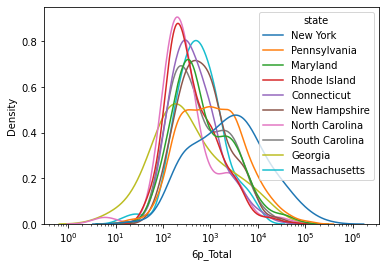

In [311]:
import seaborn as sns
sns.kdeplot(data = t.query('country == "United States"')[t.query('country == "United States"')['state'].apply(lambda x: x in ['Rhode Island','Connecticut','Maryland', 'South Carolina', 'New York','Pennsylvania', 'North Carolina', 'New Hampshire', 'Massachusetts', 'Georgia'])], x = '6p_Total', hue='state', log_scale = 10, common_norm = False)

In [274]:
print(t[t['state'].apply(lambda x: x in ['Maryland', 'Georgia', 'North Carolina', 'South Carolina', 'Virginia'])]['6p_Total'].mean(), t[t['state'].apply(lambda x: x in ['Maryland', 'Georgia', 'North Carolina', 'South Carolina', 'Virginia'])]['6p_Total'].median())
print(t[t['state'].apply(lambda x: x not in ['Maryland', 'Georgia', 'North Carolina', 'South Carolina', 'Virginia'])]['6p_Total'].mean(), t[t['state'].apply(lambda x: x not in ['Maryland', 'Georgia', 'North Carolina', 'South Carolina', 'Virginia'])]['6p_Total'].median())

1920.6544506493506 452.0
2747.926884731544 588.5


In [328]:
occ_table_grouped.sort_values('count', ascending = False).head(10)

,Occupations,6p_Total,6p_def_Total,3p_Total,count,Average (6p),6p_Total_pct,6p_def_Total_pct,3p_Total_pct,count_pct
92,merchant,865633.2828,435399.0562,575545.32,333,3907.004021,33.195553,31.585821,37.587738,21.277955
46,esquire,286067.3166,151958.6566,173070.94,212,2066.160251,10.970191,11.023770,11.302924,13.546326
57,farmer,52071.0000,30234.0000,37777.00,163,504.938650,1.996834,2.193311,2.467142,10.415335
157,yeoman,28996.0000,16930.0000,18151.00,104,441.596154,1.111947,1.228179,1.185406,6.645367
154,widow,41415.9200,21204.4600,27363.35,76,823.952368,1.588230,1.538268,1.787047,4.856230
...,...,...,...,...,...,...,...,...,...,...
62,frederick,273.0000,136.0000,135.00,1,409.000000,0.010469,0.009866,0.008817,0.063898
61,"farmer, treasurer",634.0000,366.0000,283.00,1,1000.000000,0.024313,0.026551,0.018482,0.063898
60,"farmer, school master",414.0000,257.0000,154.00,1,671.000000,0.015876,0.018644,0.010057,0.063898
59,"farmer, esquire",279.0000,190.0000,224.00,1,469.000000,0.010699,0.013783,0.014629,0.063898


In [329]:
occ_table_grouped[occ_table_grouped['count']>5].sort_values('Average (6p)', ascending = False)

,Occupations,6p_Total,6p_def_Total,3p_Total,count,Average (6p),6p_Total_pct,6p_def_Total_pct,3p_Total_pct,count_pct
148,treasurer,254474.000000,128774.000000,82549.00,21,18249.904762,9.758642,9.341850,5.391113,1.341853
103,"merchant, gentleman",41936.000000,21267.000000,17770.00,6,10533.833333,1.608174,1.542805,1.160524,0.383387
18,broker,65144.040000,58620.520000,54726.48,25,4950.582400,2.498162,4.252598,3.574079,1.597444
151,trustee,34566.000000,17808.000000,15109.00,12,4364.500000,1.325547,1.291873,0.986739,0.766773
92,merchant,865633.282800,435399.056200,575545.32,333,3907.004021,33.195553,31.585821,37.587738,21.277955
52,executor,77591.020000,46820.510000,80042.82,54,2303.917222,2.975483,3.396572,5.227440,3.450479
46,esquire,286067.316600,151958.656600,173070.94,212,2066.160251,10.970191,11.023770,11.302924,13.546326
64,gentleman,70702.630000,36538.310000,34345.62,53,2023.413962,2.711325,2.650655,2.243045,3.386581
66,gentlewoman,15729.000000,7261.000000,6201.00,13,1768.461538,0.603180,0.526746,0.404975,0.830671
116,physician,25185.000000,13448.000000,13893.00,25,1545.320000,0.965802,0.975579,0.907325,1.597444


In [318]:
occ_table_grouped.sort_values('6p_Total_pct', ascending = False)['6p_Total_pct'][:10].sum()
occ_table_grouped.sort_values('6p_Total_pct', ascending = False)['count'][:10].sum()/occ_table_grouped.sort_values('6p_Total_pct', ascending = False)['count'].sum()

0.5578274760383387

In [321]:
# use to table table 3
s = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and 'administrator' not in x and 'executor' not in x and 'esquire' not in x and 'gentleman' not in x and 'trustee' not in x and 'gentlewomen' not in x)]['6p_Total_pct'].sum()
c = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and 'administrator' not in x and 'executor' not in x and 'esquire' not in x and 'gentleman' not in x and 'trustee' not in x and 'gentlewomen' not in x)]['count'].sum()
print(s, c, s/c * occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and 'administrator' not in x and 'executor' not in x and 'esquire' not in x and 'gentleman' not in x and 'trustee' not in x and 'gentlewomen' not in x)][['6p_Total', '6p_def_Total']].sum().sum()/100)
s = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x or 'gentlewomen' in x))]['6p_Total_pct'].sum()
c = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x or 'gentlewomen' in x))]['count'].sum()
print(s, c, s/c * occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x or 'gentlewomen' in x))][['6p_Total', '6p_def_Total']].sum().sum()/100)
s = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: 'merchant' not in x and 'trader' not in x and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x or 'gentlewomen' in x))]['6p_Total_pct'].sum()
c = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: 'merchant' not in x and 'trader' not in x and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x or 'gentlewomen' in x))]['count'].sum()
print(s, c, s/c * occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: 'merchant' not in x and 'trader' not in x and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x or 'gentlewomen' in x))][['6p_Total', '6p_def_Total']].sum().sum()/100)

38.315279608794235 399 1445.17777032919
6.552916872533511 15 1125.5508450825976
23.489513082253524 387 572.0348577247596


In [353]:
state_fn = ['Rhode Island', 'New York', 'Pennsylvania', 'New Hampshire', 'New Jersey',
            'Delaware', 'Massachusetts', 'Vermont']
occ_table_grouped_s = occ_table[occ_table['state'].apply(lambda x: x in state_fn)].groupby(['Occ_str']).agg({'6p_Total': sum, '6p_def_Total': sum,
                                                                                          '3p_Total': sum,'count': sum}).reset_index()
occ_table_grouped_s.columns = ['Occupations', '6p_Total', '6p_def_Total', '3p_Total', 'count']
occ_table_grouped_s['state'] = " ".join(state_fn)

occ_table_grouped_s['Average (6p)'] = occ_table_grouped_s['6p_Total'] / occ_table_grouped_s['count']
for col in ['6p_Total', '6p_def_Total', '3p_Total', 'count']:
    occ_table_grouped_s[col + "_pct"] = occ_table_grouped_s[col] / occ_table_grouped_s[occ_table_grouped_s['Occupations']!=""][col].sum() * 100
for col in occ_table_grouped_s.columns[1:]:
    if col != 'state':
        occ_table_grouped_s[col] = occ_table_grouped_s[col].apply(lambda x: round(x, 2))
print(occ_table_grouped_s[occ_table_grouped_s['Occupations'].apply(lambda x: 'merchant' in x)].sort_values('6p_Total', ascending = False)['6p_Total_pct'].sum())
print(occ_table_grouped_s[occ_table_grouped_s['Occupations'].apply(lambda x: 'esquire' in x or 'gentlewoman' in x or 'gentleman' in x or 'executor' in x or 'trustee' in x or 'administrator' in x)].sort_values('6p_Total', ascending = False)['6p_Total_pct'].sum())

43.31
32.55


In [354]:
state_fn = ['Virginia', 'Maryland',  'North Carolina', 'South Carolina', 'Georgia']
occ_table_grouped_s = occ_table[occ_table['state'].apply(lambda x: x in state_fn)].groupby(['Occ_str']).agg({'6p_Total': sum, '6p_def_Total': sum,
                                                                                                             '3p_Total': sum,'count': sum}).reset_index()
occ_table_grouped_s.columns = ['Occupations', '6p_Total', '6p_def_Total', '3p_Total', 'count']
occ_table_grouped_s['state'] = " ".join(state_fn)

occ_table_grouped_s['Average (6p)'] = occ_table_grouped_s['6p_Total'] / occ_table_grouped_s['count']
for col in ['6p_Total', '6p_def_Total', '3p_Total', 'count']:
    occ_table_grouped_s[col + "_pct"] = occ_table_grouped_s[col] / occ_table_grouped_s[occ_table_grouped_s['Occupations']!=""][col].sum() * 100
for col in occ_table_grouped_s.columns[1:]:
    if col != 'state':
        occ_table_grouped_s[col] = occ_table_grouped_s[col].apply(lambda x: round(x, 2))
print(occ_table_grouped_s[occ_table_grouped_s['Occupations'].apply(lambda x: 'merchant' in x)].sort_values('6p_Total', ascending = False)['6p_Total_pct'].sum())
print(occ_table_grouped_s[occ_table_grouped_s['Occupations'].apply(lambda x: 'esquire' in x or 'gentlewoman' in x or 'gentleman' in x or 'executor' in x or 'trustee' in x or 'administrator' in x)].sort_values('6p_Total', ascending = False)['6p_Total_pct'].sum())

59.42
18.76
